In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("./PCA_data/AAPL.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,Close
0,-1.540483,1.091264,-1.904682,1.023054,-1.610737,-0.457409,-0.976029,-0.176732,-0.435118,0.478131,...,0.594647,-1.798719,0.410359,0.450158,1.018942,-0.555013,-0.408963,-0.376990,0.630134,242.929993
1,-1.482503,1.663316,-2.022443,1.178359,-1.293561,-0.935631,0.196909,0.642453,0.609026,0.982299,...,1.003494,-0.383835,-0.033271,0.560352,0.596939,-0.556418,-0.543539,-0.417217,0.365991,242.789993
2,-1.515986,0.908653,-1.742349,0.279382,-1.786337,-0.621862,0.171432,-0.073792,0.768102,1.199737,...,-0.089080,0.481177,-0.268350,-1.162471,-0.360505,1.451247,-0.649178,-0.160071,0.038219,242.997101
3,-1.507207,1.504773,-1.953247,0.780044,-1.139244,-0.770421,1.994797,1.910108,0.250264,1.109654,...,-1.528903,0.125449,-0.547690,-1.580888,-0.156410,0.334201,-0.736637,0.242141,0.040221,242.919998
4,-1.438237,2.371049,-2.114689,1.259357,-0.693816,-0.986994,0.749530,1.705507,-1.528096,-1.428627,...,1.497952,-0.000800,-0.679917,-0.721003,0.125817,0.350791,-0.594471,-0.229388,0.141762,242.610992


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3385 entries, 0 to 3384
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pca1    3385 non-null   float64
 1   pca2    3385 non-null   float64
 2   pca3    3385 non-null   float64
 3   pca4    3385 non-null   float64
 4   pca5    3385 non-null   float64
 5   pca6    3385 non-null   float64
 6   pca7    3385 non-null   float64
 7   pca8    3385 non-null   float64
 8   pca9    3385 non-null   float64
 9   pca10   3385 non-null   float64
 10  pca11   3385 non-null   float64
 11  pca12   3385 non-null   float64
 12  pca13   3385 non-null   float64
 13  pca14   3385 non-null   float64
 14  pca15   3385 non-null   float64
 15  pca16   3385 non-null   float64
 16  pca17   3385 non-null   float64
 17  pca18   3385 non-null   float64
 18  pca19   3385 non-null   float64
 19  pca20   3385 non-null   float64
 20  Close   3385 non-null   float64
dtypes: float64(21)
memory usage: 555.5 KB

In [4]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

## Sliding Window

In [6]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

## HyperParameters

In [7]:
sliding_window_size = 10
testing_duration = 1600
training_duration = 1700

## Train Test Split

In [8]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1700, 20) trainY: (1700,)
testX: (1600, 20) testY: (1600,)


In [9]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [10]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1700, 20) trainY: (1700, 1)
testX: (1600, 20) testY: (1600, 1)


In [11]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([1690, 10, 20]) train_y: torch.Size([1690, 1]) train_y_gan: torch.Size([1690, 11, 1])
test_x: torch.Size([1590, 10, 20]) test_y: torch.Size([1590, 1]) test_y_gan: torch.Size([1590, 11, 1])


## WGAN Model Implementation

In [12]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 GRU layers, input_size = features
    self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
    self.gru_2 = nn.GRU(1024, 512, batch_first = True)
    self.gru_3 = nn.GRU(512, 256, batch_first = True)
    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 1)

    self.dropout = nn.Dropout(0.3)


  def forward(self, x):
    use_cuda = 1
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
    h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
    out_gru_1, _ = self.gru_1(x, h0)
    out_gru_1 = self.dropout(out_gru_1)

    h1 = torch.zeros(1, x.size(0), 512).to(device)
    out_gru_2, _ = self.gru_2(out_gru_1, h1)
    out_gru_2 = self.dropout(out_gru_2)

    h2 = torch.zeros(1, x.size(0), 256).to(device)
    out_gru_3, _ = self.gru_3(out_gru_2, h2)
    out_gru_3 = self.dropout(out_gru_3)

    out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)
    
    return out_dense_3

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+1, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 1)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

In [14]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final

In [15]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


In [16]:
batch_size = 128
learning_rate = 0.00005
num_epochs = 1000
critic_iterations = 10

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

# Give number of features to the G
modelG = Generator(train_x.shape[1]).to(device)
modelD = Discriminator().to(device)

#weight_decay-L2 penalty to the weights
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

# optimizerG = torch.optim.RMSprop(modelG.parameters(), lr = learning_rate, weight_decay = 1e-3)
# optimizerD = torch.optim.RMSprop(modelD.parameters(), lr = learning_rate, weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

#k=0
i=0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
    
        fake_data = modelG(x)
        i=1
        fake_data = torch.cat([y[:, :sliding_window_size, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        
        for _ in range(critic_iterations):
            critic_real = modelD(y)
            critic_fake = modelD(fake_data)
            grad_penalty, grad_norm_ = grad_penalty_fnc(y, fake_data,modelD,cuda,5)
            # Take probability mean of whole batch.
            lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + grad_penalty

            modelD.zero_grad()
            lossD.backward(retain_graph = True)
            optimizerD.step()
    
        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)

        modelG.zero_grad() # zeroing the gradients
        lossG.backward() # computing the gradients
        optimizerG.step() # updating the parameters

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())
    
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

c:\Users\usith\anaconda3\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1/1000] LossD: -0.04685521312057972 LossG:0.3982682414352894
[2/1000] LossD: -0.3159896917641163 LossG:0.5614676643162966
[3/1000] LossD: 0.06635165959596634 LossG:0.4884118065237999
[4/1000] LossD: 0.006230127066373825 LossG:0.34417747892439365
[5/1000] LossD: -0.02989506721496582 LossG:0.39093962125480175
[6/1000] LossD: -0.03088395856320858 LossG:0.4192430730909109
[7/1000] LossD: -0.08935676328837872 LossG:0.5066474284976721
[8/1000] LossD: -0.23132827342487872 LossG:0.602459317073226
[9/1000] LossD: -0.5178138166666031 LossG:0.4746154975146055
[10/1000] LossD: -1.1838056249544024 LossG:0.773153462447226
[11/1000] LossD: -2.1959211188657815 LossG:1.1920070764608681
[12/1000] LossD: -2.263501111489677 LossG:0.850777605548501
[13/1000] LossD: -2.1901668337732585 LossG:0.6253638137131929
[14/1000] LossD: -2.061931681231422 LossG:0.34981484804302454
[15/1000] LossD: -1.8612831303383772 LossG:0.061122210463508964
[16/1000] LossD: -1.66129061307862 LossG:-0.07110647670924664
[17/1000] L

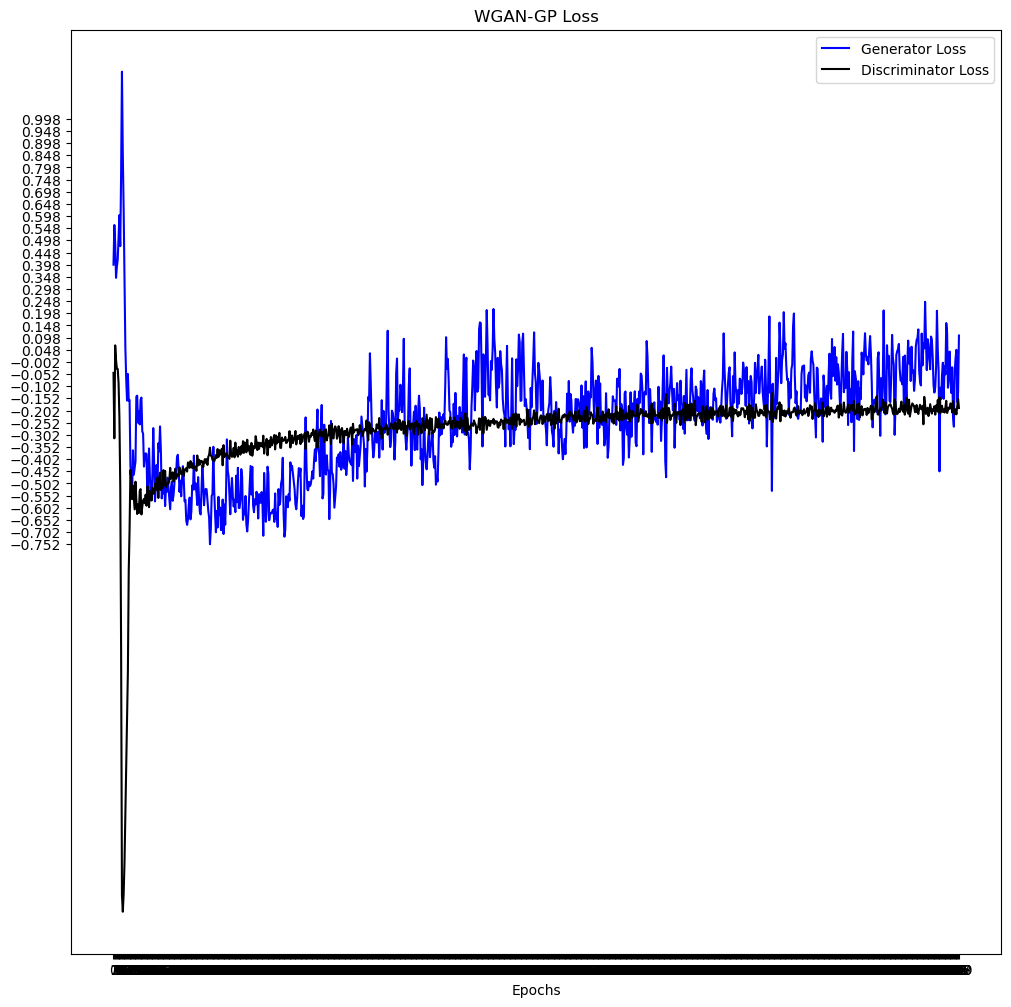

In [17]:
plt.figure(figsize = (12, 12))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.xticks(np.arange(0, num_epochs, 1.0))
plt.yticks(np.arange(min(histG), 1, 0.05))
plt.title('WGAN-GP Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [18]:
train_y_slide.shape

torch.Size([1690, 1])

In [19]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.7278940865555955


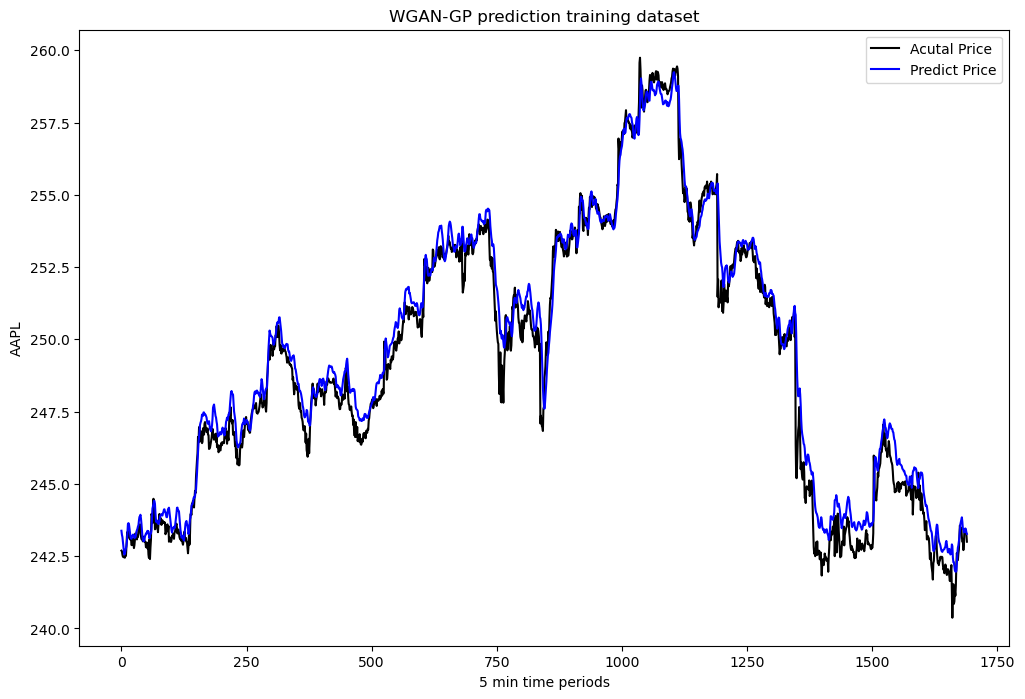

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('AAPL')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:1.8940390931903435


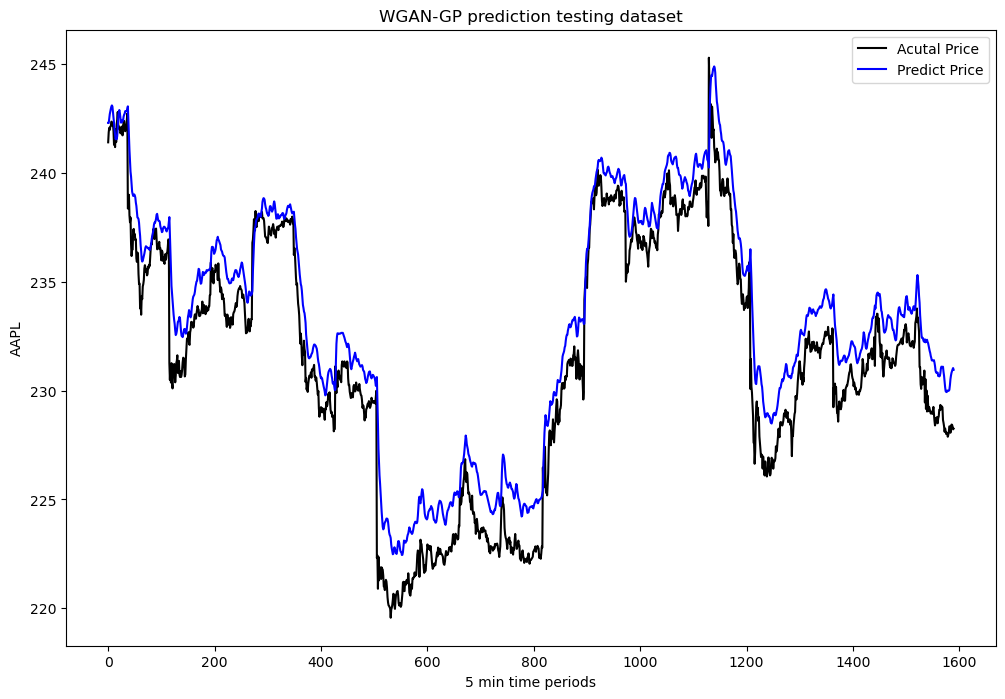

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('AAPL')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')